<a href="https://colab.research.google.com/github/sajtarius/cross-synchrony/blob/main/synchro_example/cross_synchrony_entropy%26divergence_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Here, I will compare the **cross synchrony entropy** along with **global field synchrony** through a coupled system of Duffing-van
der Pol oscillators that perturbated by white noise. This model is a phenomenological model of the EEG <a href='https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10969156/'>reference 1</a>.

The general process of this section is as follows:
1. The signals are simulated based on coupled system of Duffing-van der Pol oscillators.
2. The signals are saved as .set format for the ease of extracting specific frequency range (by using mne library).
3. The signals then undergo the [global field sychronization] and [cross synchrony entropy] calculation. The calculated data are saved in .tsv format.
4. The results of comparison are shown along with the simulated signals.

reference:
1. <a href='https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10969156/'>Information Geometry Theoretic Measures for Characterizing Neural Information Processing from Simulated EEG Signals</a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Insert the directory
import sys
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks')

# Libraries

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from joblib import Parallel, delayed

In [11]:
# @title simulation for stochastic nonlinear oscillator models of EEG signals
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

# Parameters
fs=500
num_steps = 100_000
num_simulations = 50
dt = 1/fs  # Time step
time_range = np.arange(0, num_steps * dt, dt)


#########################################
int_parti = 'EC_alzheimer'
if int_parti == 'EC_healthy':
    #EC healthy
    k1 = 7286.5
    k2 = 4523.5
    b1 = 232.05
    b2 = 10.78
    e1 = 33.60
    e2 = 0.97
    sigma = 2.34  # Noise strength

elif int_parti == 'EO_healthy':
    #EO healthy
    k1 = 2427.2
    k2 = 499.92
    b1 = 95.61
    b2 = 103.36
    e1 = 48.89
    e2 = 28.75
    sigma = 1.82  # Noise strength

elif int_parti == 'EC_alzheimer':
    #EC Alzheimer
    k1 = 1742.1
    k2 = 1270.8
    b1 = 771.99
    b2 = 1.91
    e1 = 63.7
    e2 = 20.7
    sigma = 1.78  # Noise strength

elif int_parti == 'EO_alzheimer':
    #EO Alzheimer
    k1 = 3139.9
    k2 = 650.32
    b1 = 101.1
    b2 = 81.3
    e1 = 56.3
    e2 = 19.12
    sigma = 1.74  # Noise strength
#########################################

# Generate noise for all simulations
noise_x = np.random.normal(0, np.sqrt(dt), (num_simulations, num_steps))

# Initialize arrays to store results for all simulations
x1 = np.zeros((num_simulations, num_steps))
x2 = np.zeros((num_simulations, num_steps))
x3 = np.zeros((num_simulations, num_steps))
x4 = np.zeros((num_simulations, num_steps))

#########################################
# Initial conditions; random initial start
x1[:, 0] = np.random.normal(1.0, 0.1, num_simulations)
x2[:, 0] = np.random.normal(0.5, 0.1, num_simulations)
x3[:, 0] = np.random.normal(0.0, 0.1, num_simulations)
x4[:, 0] = np.random.normal(0.0, 0.1, num_simulations)

# Initial conditions; initial start at 0
'''x1[:, 0] = 0
x2[:, 0] = 0
x3[:, 0] = 0
x4[:, 0] = 0'''
#########################################

# Generate coupled time series for all simulations
for t in tqdm(range(1, num_steps), position=0):
    dx1 = x3[:, t-1] * dt
    dx2 = x4[:, t-1] * dt
    dx3 = (-(k1 + k2)*x1[:, t-1] + k2*x2[:, t-1] - b1*(x1[:, t-1]**3) - b2*((x1[:, t-1]-x2[:, t-1])**3) + e1*x3[:, t-1]*(1-(x1[:, t-1]**2))) * dt
    dx4 = (k2*x1[:, t-1] - k2*x2[:, t-1] + b2*((x1[:, t-1]-x2[:, t-1])**3) + e2*x4[:, t-1]*(1-(x2[:, t-1]**2)))*dt + sigma*noise_x[:, t] * dt**(0)
    x1[:, t] = x1[:, t-1] + dx1
    x2[:, t] = x2[:, t-1] + dx2
    x3[:, t] = x3[:, t-1] + dx3
    x4[:, t] = x4[:, t-1] + dx4

100%|██████████| 99999/99999 [00:16<00:00, 5901.00it/s]


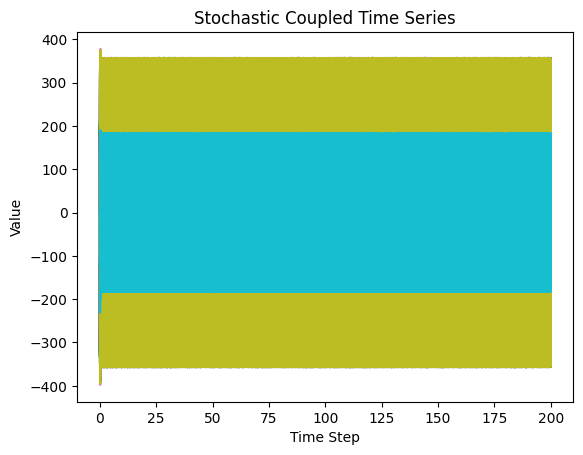

In [36]:
# Plot the time series for the first 10 simulations
for i in range(num_simulations):
    #plt.plot(time_range, x1[i], label=f'x1_sim_{i+1}')
    #plt.plot(time_range, x2[i], label=f'x2_sim_{i+1}')
    plt.plot(time_range, x3[i], label=f'x3_sim_{i+1}')
    plt.plot(time_range, x4[i], label=f'x4_sim_{i+1}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Stochastic Coupled Time Series')
#plt.xlim(0,1)
plt.show()

In [12]:
# @title install other libraries
# [mne], [bids], and [eeglabio] are used for the ease of getting the specfic frequency band
# when conducting the [cross synchrony entropy] and [cross synchrony divergence] calculation.

!pip install mne
!pip install bids
!pip install eeglabio

In [13]:
# @title save the simulated signals to .set format
import mne

from bids import BIDSLayout
from bids.tests import get_test_data_path

import sys
from io import StringIO

file_name = int_parti
file_path = f'/content/drive/MyDrive/sim_eeg_signal/{file_name}'
sim = num_simulations
strt_part = 10_000
sample_freq = 1/dt

for i in range(sim):
    # Suppressing printed output
    stdout_backup = sys.stdout
    sys.stdout = StringIO()

    temp_spread = np.array([x3[i][strt_part:], x4[i][strt_part:]]) #save from [strt_part] because the signals are no "stable" at the first few seconds.
    temp_df = pd.DataFrame(temp_spread.T, columns=['x3', 'x4'])

    info_data = mne.create_info(ch_names=temp_df.columns.to_list(), sfreq=sample_freq, ch_types='eeg')
    raw_data = mne.io.RawArray(temp_df.T, info_data)
    mne.export.export_raw(f'{file_path}/{file_name}{i}.set', raw_data, overwrite=True)

# Small demontration of [cross synchrony entropy]

In [140]:
# @title Demonstration of the [Cross Synchrony Entropy] for [eyes closed alzheimer]
import mne

i = 0 #index for the participant
int_bins = 50 #bin size for the probability distribution
fmin, fmax = 0.5, 50 #interested frequency range; (0, 0) is for whole frequency range.

file_name = 'EC_alzheimer'
file_path = f'/content/drive/MyDrive/sim_eeg_signal/{file_name}'
temp_eeg_data = mne.io.read_raw_eeglab(f'{file_path}/{file_name}{i}.set', preload=True)
if (fmin > 0) and (fmax > 0):
    temp_eeg_data = temp_eeg_data.filter(fmin, fmax)
temp_eeg_data_all = temp_eeg_data.get_data()
temp_phase_lock_eeg = sc.phase_lock_seq(temp_eeg_data_all)
temp_cross_synch_en, temp_cross_synch_en_pmf, temp_cross_synch_en_edges = sc.cross_synch_sys_en(temp_phase_lock_eeg, exp_range=int_range, bins=int_bins, check_pdf_info=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (6.602 s)



100%|██████████| 2/2 [00:00<00:00, 87.28it/s]


DATA MUST BE A [PHASE LOCK MATRIX]; USE [phase_lock_seq()] function.


100%|██████████| 90000/90000 [00:00<00:00, 146927.92it/s]


check PMF of data: 	 1.0000000000000007
mean of data: 	 -0.5310537777777782
std of data: 	 0.4400755700219827
bin size of PMF: 50
max entropy: 3.912023005428146


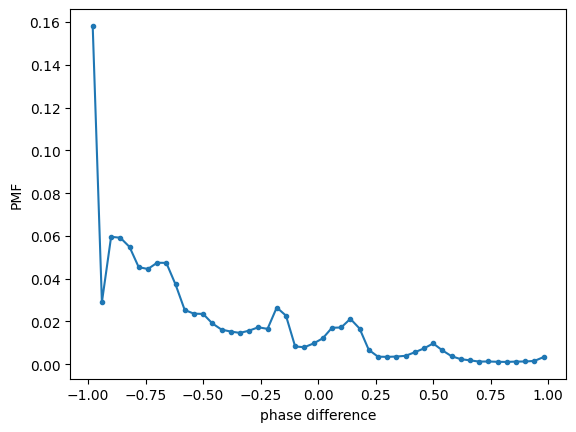

In [141]:
# @title plot of the [Probability Mass Distribution] vs [phase difference]
plt.figure()
plt.plot(0.5*(temp_cross_synch_en_edges[1:]+temp_cross_synch_en_edges[:-1]), temp_cross_synch_en_pmf, '.-')
plt.ylabel('PMF')
plt.xlabel('phase difference')
plt.show()

In [138]:
# @title Demonstration of the [Cross Synchrony Entropy] for [eyes closed healthy]
import mne

i = 0 #index for the participant
int_bins = 50 #bin size for the probability distribution
fmin, fmax = 0.5, 50 #interested frequency range; (0, 0) is for whole frequency range.

file_name = 'EC_healthy'
file_path = f'/content/drive/MyDrive/sim_eeg_signal/{file_name}'
temp_eeg_data = mne.io.read_raw_eeglab(f'{file_path}/{file_name}{i}.set', preload=True)
if (fmin > 0) and (fmax > 0):
    temp_eeg_data = temp_eeg_data.filter(fmin, fmax)
temp_eeg_data_all = temp_eeg_data.get_data()
temp_phase_lock_eeg = sc.phase_lock_seq(temp_eeg_data_all)
temp_cross_synch_en, temp_cross_synch_en_pmf, temp_cross_synch_en_edges = sc.cross_synch_sys_en(temp_phase_lock_eeg, exp_range=int_range, bins=int_bins, check_pdf_info=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (6.602 s)



100%|██████████| 2/2 [00:00<00:00, 219.32it/s]


DATA MUST BE A [PHASE LOCK MATRIX]; USE [phase_lock_seq()] function.


100%|██████████| 90000/90000 [00:00<00:00, 251017.64it/s]


check PMF of data: 	 1.0000000000000007
mean of data: 	 -0.9310973333333339
std of data: 	 0.04600034146733164
bin size of PMF: 50
max entropy: 3.912023005428146


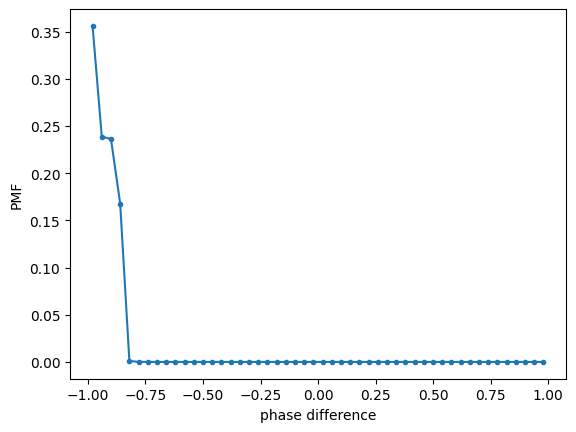

In [139]:
# @title plot of the [Probability Mass Distribution] vs [phase difference]
plt.figure()
plt.plot(0.5*(temp_cross_synch_en_edges[1:]+temp_cross_synch_en_edges[:-1]), temp_cross_synch_en_pmf, '.-')
plt.ylabel('PMF')
plt.xlabel('phase difference')
plt.show()

# [Cross synchrony entropy] analysis

In [8]:
# @title cross synchrony entropy calculation
import mne
import synchro_code as sc

import sys
from io import StringIO

######################################################################
# counting the number of files within a folder
from pathlib import Path

def count_files_in_folder(folder_path):
    folder = Path(folder_path)
    return sum(1 for item in folder.iterdir() if item.is_file())
######################################################################

file_path = '/content/drive/MyDrive/sim_eeg_signal'
file_name = 'EC_alzheimer'
fmin, fmax = 0.5, 50
int_range = 1
int_bins = 20

file_count = count_files_in_folder(f'{file_path}/{file_name}') #count how many files within a folder

participant_data = []
cross_synch_en_data = []
for i in tqdm(range(file_count), position=0):
    # Suppressing printed output
    stdout_backup = sys.stdout
    sys.stdout = StringIO()

    temp_eeg_data = mne.io.read_raw_eeglab(f'{file_path}/{file_name}/{file_name}{i}.set', preload=True)
    if (fmin > 0) and (fmax > 0):
        temp_eeg_data = temp_eeg_data.filter(fmin, fmax)

    temp_eeg_data_all = temp_eeg_data.get_data()
    temp_phase_lock_eeg = sc.phase_lock_seq(temp_eeg_data_all)
    temp_cross_synch_en, _, _ = sc.cross_synch_sys_en(temp_phase_lock_eeg, exp_range=int_range, bins=int_bins, check_pdf_info=False)

    participant_data.append(f'{file_name}{i}')
    cross_synch_en_data.append(f'{temp_cross_synch_en}')

temp_savedata = np.vstack((participant_data, cross_synch_en_data)).T
df_savedata = pd.DataFrame(temp_savedata, columns=['participant_id', 'cross_synch_enpy'])
df_savedata.to_csv(f'{file_path}/{file_name}_cross_synch_en_freq{fmin}-{fmax}_range{int_range}_bins{int_bins}.tsv', index=False, sep='\t')

100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


# Demonstration of [Global Field Synchronization]

In [148]:
# @title Compute the [Fourier Transform] for [eyes closed alzheimer] & [global field synchronization calculation]
from scipy.fft import rfft, rfftfreq

file_path = '/content/drive/MyDrive/sim_eeg_signal'
file_name = 'EC_alzheimer'

temp_data = mne.io.read_raw_eeglab(f'{file_path}/{file_name}/{file_name}{i}.set', preload=True)
temp_fs = temp_data.info['sfreq']
print(f'sampling frequency: {temp_fs}')
temp_time = temp_data.times
temp_data = temp_data.get_data()

temp_fftcomp = rfft(temp_data[0])
temp_fftamp = np.abs(temp_fftcomp)
temp_fftfreq = rfftfreq(temp_time.shape[0], d=np.diff(temp_time)[0])

temp_fftcomp1 = rfft(temp_data[1])
temp_fftamp1 = np.abs(temp_fftcomp1)
temp_fftfreq1 = rfftfreq(temp_time.shape[0], d=np.diff(temp_time)[0])

# [global field synchronization]
freqrange = (0.5, 50)
step_freq = 0.002
int_freqrange = np.arange(*freqrange, step_freq)
def process_data(temp_data, freq, time):
    temp_global_data = sc.global_func_connect(temp_data, freq, time)
    return sc.global_field_sync(temp_global_data)

data_all = temp_data
data_time = temp_time
gfs_range = Parallel(n_jobs=30)(
    delayed(process_data)(data_all, int_freqrange[i], data_time) for i in tqdm(range(len(int_freqrange)), position=0)
)
gfs_mean = np.mean(gfs_range)
gfs_std = np.std(gfs_range)
print(f'global field synchronization: {gfs_mean} +/- {gfs_std}')

sampling frequency: 500.0


100%|██████████| 24750/24750 [07:51<00:00, 52.49it/s]


global field synchronization: 1.0 +/- 0.0


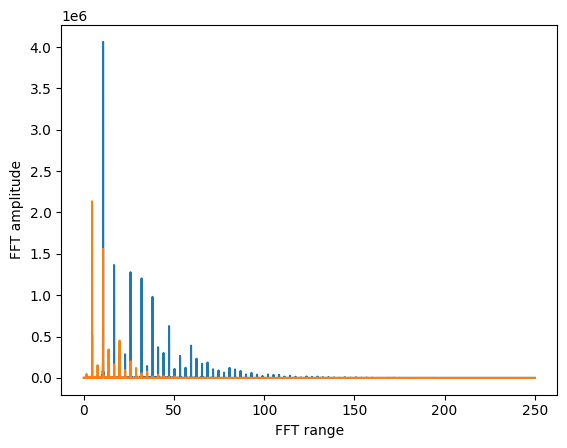

In [118]:
# @title plot of the [frequency spectrum]
plt.figure()
plt.plot(temp_fftfreq, temp_fftamp)
plt.plot(temp_fftfreq1, temp_fftamp1)
plt.ylabel('FFT amplitude')
plt.xlabel('FFT range')
plt.show()

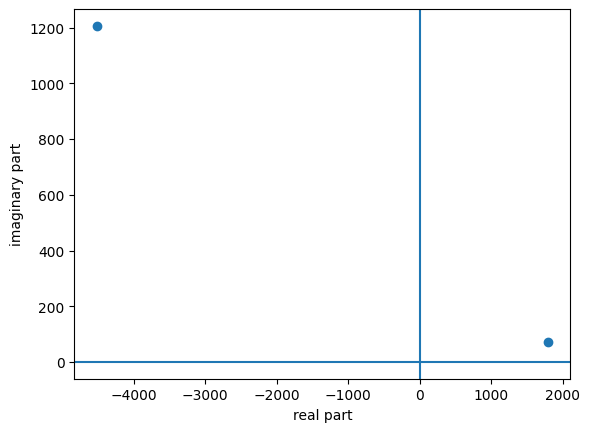

In [90]:
int_freq = 5
index_freq = np.where(temp_fftfreq <= int_freq)[0][-1]
index_freq1 = np.where(temp_fftfreq1 <= int_freq)[0][-1]

temp_compdata = np.vstack((temp_fftcomp, temp_fftcomp1))

plt.figure()
plt.plot(np.real(temp_compdata[:, index_freq]), np.imag(temp_compdata[:, index_freq]), 'o')
plt.axhline(0)
plt.axvline(0)
plt.xlabel('real part')
plt.ylabel('imaginary part')
plt.show()

In [149]:
# @title Compute the [Fourier Transform] for [eyes closed healthy] & [global field synchronization calculation]
from scipy.fft import rfft, rfftfreq

file_path = '/content/drive/MyDrive/sim_eeg_signal'
file_name = 'EC_healthy'

temp_data = mne.io.read_raw_eeglab(f'{file_path}/{file_name}/{file_name}{i}.set', preload=True)
temp_fs = temp_data.info['sfreq']
print(f'sampling frequency: {temp_fs}')
temp_time = temp_data.times
temp_data = temp_data.get_data()

temp_fftcomp = rfft(temp_data[0])
temp_fftamp = np.abs(temp_fftcomp)
temp_fftfreq = rfftfreq(temp_time.shape[0], d=np.diff(temp_time)[0])

temp_fftcomp1 = rfft(temp_data[1])
temp_fftamp1 = np.abs(temp_fftcomp1)
temp_fftfreq1 = rfftfreq(temp_time.shape[0], d=np.diff(temp_time)[0])

# [global field synchronization]
freqrange = (0.5, 50)
step_freq = 0.002
int_freqrange = np.arange(*freqrange, step_freq)
def process_data(temp_data, freq, time):
    temp_global_data = sc.global_func_connect(temp_data, freq, time)
    return sc.global_field_sync(temp_global_data)

data_all = temp_data
data_time = temp_time
gfs_range = Parallel(n_jobs=30)(
    delayed(process_data)(data_all, int_freqrange[i], data_time) for i in tqdm(range(len(int_freqrange)), position=0)
)
gfs_mean = np.mean(gfs_range)
gfs_std = np.std(gfs_range)
print(f'global field synchronization: {gfs_mean} +/- {gfs_std}')

sampling frequency: 500.0


100%|██████████| 24750/24750 [07:07<00:00, 57.96it/s]


global field synchronization: 1.0 +/- 0.0


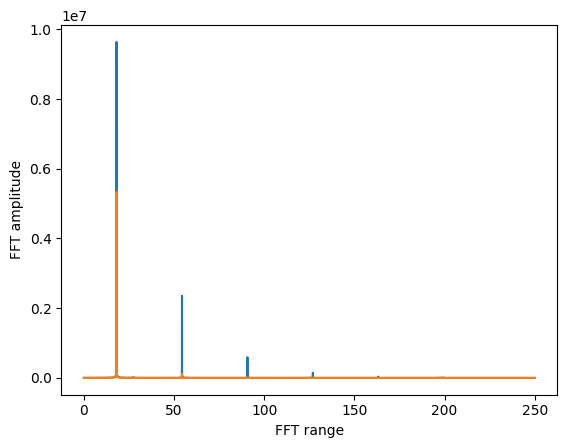

In [92]:
# @title plot of the [frequency spectrum]
plt.figure()
plt.plot(temp_fftfreq, temp_fftamp)
plt.plot(temp_fftfreq1, temp_fftamp1)
plt.ylabel('FFT amplitude')
plt.xlabel('FFT range')
plt.show()

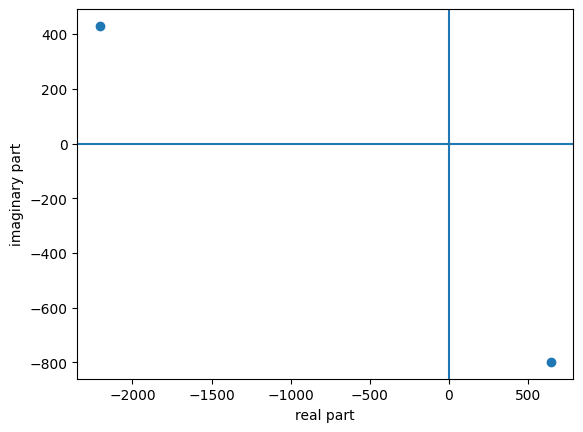

In [93]:
int_freq = 5
index_freq = np.where(temp_fftfreq <= int_freq)[0][-1]
index_freq1 = np.where(temp_fftfreq1 <= int_freq)[0][-1]

temp_compdata = np.vstack((temp_fftcomp, temp_fftcomp1))

plt.figure()
plt.plot(np.real(temp_compdata[:, index_freq]), np.imag(temp_compdata[:, index_freq]), 'o')
plt.axhline(0)
plt.axvline(0)
plt.xlabel('real part')
plt.ylabel('imaginary part')
plt.show()

# [Global field synchronization] analysis

In [9]:
# @title global field synchronization calculation

import synchro_code as sc

from tqdm import tqdm
from joblib import Parallel, delayed

######################################################################
# counting the number of files within a folder
from pathlib import Path

def count_files_in_folder(folder_path):
    folder = Path(folder_path)
    return sum(1 for item in folder.iterdir() if item.is_file())
######################################################################

file_path = '/content/drive/MyDrive/sim_eeg_signal'
file_name = 'EC_healthy'
freqrange = (0.5, 50) #define the frequency range
step_freq = 0.1 #interval within the frequency range

file_count = count_files_in_folder(f'{file_path}/{file_name}') #count how many files within a folder

participant_id_data = []
gfs_mean_data = []
gfs_std_data = []

for i in tqdm(range(file_count)):
    temp_data = mne.io.read_raw_eeglab(f'{file_path}/{file_name}/{file_name}{i}.set', preload=True) #read the data
    temp_participant_id = f'{file_name}{i}'

    if (np.min(freqrange) > 0) and (np.max(freqrange) > 0):
        int_freqrange = np.arange(*freqrange, step_freq)
    else:
        int_freqrange = np.arange(0, temp_data.info['sfreq']/2, step_freq)

    def process_data(temp_data, freq, time):
        temp_global_data = sc.global_func_connect(temp_data, freq, time)
        return sc.global_field_sync(temp_global_data)

    data_all = temp_data.get_data()
    data_time = temp_data.times
    gfs_range = Parallel(n_jobs=30)(
        delayed(process_data)(data_all, int_freqrange[i], data_time) for i in tqdm(range(len(int_freqrange)), position=0, disable=True)
    )

    participant_id_data.append(temp_participant_id)
    gfs_mean_data.append(np.mean(gfs_range))
    gfs_std_data.append(np.std(gfs_range))

temp_save_data = np.vstack((participant_id_data, gfs_mean_data, gfs_std_data))
temp_save_data = temp_save_data.T

df_gfs = pd.DataFrame(temp_save_data, columns=['participant_id', 'gfs_mean', 'gfs_std'])

df_gfs.to_csv(f'{file_path}/{file_name}_gfs_freq{np.min(freqrange)}-{np.max(freqrange)}_step{step_freq}.tsv', sep='\t', index=False)

100%|██████████| 50/50 [07:20<00:00,  8.82s/it]


# Comparison of TWO Methods
Here shows the results of [Cross Synchrony Entropy] and [Global Field Synchronization] of the simulated signals

In [127]:
# @title get all the calculated data of [cross synchrony entropy] and [global field synchronization]
temp_file = 'drive/MyDrive/sim_eeg_signal'

temp_cross_en_result = pd.read_csv(f'{temp_file}/EC_healthy_cross_synch_en_freq0.5-50_range1_bins20.tsv', sep='\t')
temp_cross_en_result1 = pd.read_csv(f'{temp_file}/EC_alzheimer_cross_synch_en_freq0.5-50_range1_bins20.tsv', sep='\t')
temp_cross_en_result_all = pd.concat([temp_cross_en_result, temp_cross_en_result1], axis=1)

temp_global_result = pd.read_csv(f'{temp_file}/EC_healthy_gfs_freq0.5-50.0_step0.1.tsv', sep='\t')
temp_global_result1 = pd.read_csv(f'{temp_file}/EC_alzheimer_gfs_freq0.5-50.0_step0.1.tsv', sep='\t')
temp_global_result_all = pd.concat([temp_global_result, temp_global_result1], axis=1)

In [130]:
# @title global field synchronization data
print(temp_global_result_all)

   participant_id  gfs_mean  gfs_std  participant_id  gfs_mean  gfs_std
0     EC_healthy0       1.0      0.0   EC_alzheimer0       1.0      0.0
1     EC_healthy1       1.0      0.0   EC_alzheimer1       1.0      0.0
2     EC_healthy2       1.0      0.0   EC_alzheimer2       1.0      0.0
3     EC_healthy3       1.0      0.0   EC_alzheimer3       1.0      0.0
4     EC_healthy4       1.0      0.0   EC_alzheimer4       1.0      0.0
5     EC_healthy5       1.0      0.0   EC_alzheimer5       1.0      0.0
6     EC_healthy6       1.0      0.0   EC_alzheimer6       1.0      0.0
7     EC_healthy7       1.0      0.0   EC_alzheimer7       1.0      0.0
8     EC_healthy8       1.0      0.0   EC_alzheimer8       1.0      0.0
9     EC_healthy9       1.0      0.0   EC_alzheimer9       1.0      0.0
10   EC_healthy10       1.0      0.0  EC_alzheimer10       1.0      0.0
11   EC_healthy11       1.0      0.0  EC_alzheimer11       1.0      0.0
12   EC_healthy12       1.0      0.0  EC_alzheimer12       1.0  

In [154]:
# @title cross synchrony entropy data
print(temp_cross_en_result_all)

   participant_id  cross_synch_enpy  participant_id  cross_synch_enpy
0     EC_healthy0          0.611915   EC_alzheimer0          2.495694
1     EC_healthy1          0.612574   EC_alzheimer1          2.495995
2     EC_healthy2          0.612493   EC_alzheimer2          2.496505
3     EC_healthy3          0.612527   EC_alzheimer3          2.495234
4     EC_healthy4          0.611345   EC_alzheimer4          2.495603
5     EC_healthy5          0.612264   EC_alzheimer5          2.496909
6     EC_healthy6          0.612051   EC_alzheimer6          2.495890
7     EC_healthy7          0.612153   EC_alzheimer7          2.496072
8     EC_healthy8          0.612579   EC_alzheimer8          2.494534
9     EC_healthy9          0.612128   EC_alzheimer9          2.495892
10   EC_healthy10          0.612047  EC_alzheimer10          2.496077
11   EC_healthy11          0.611966  EC_alzheimer11          2.494218
12   EC_healthy12          0.612472  EC_alzheimer12          2.495305
13   EC_healthy13   

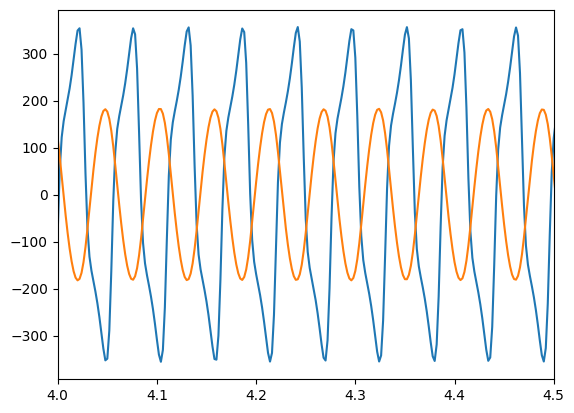

In [136]:
# @title simulated signal of the [eyes closed healthy]
file_path = 'drive/MyDrive/sim_eeg_signal'
file_group = 'EC_healthy'

temp_ec_healthy = mne.io.read_raw_eeglab(f'{file_path}/{file_group}/{file_group}0.set', preload=True)
temp_ec_healthy_data = temp_ec_healthy.get_data()
temp_ec_healthy_time = temp_ec_healthy.times

plt.figure()
plt.plot(temp_ec_healthy_time, temp_ec_healthy_data[0], label='x3')
plt.plot(temp_ec_healthy_time, temp_ec_healthy_data[1], label='x4')
plt.xlim(4, 4.5)
plt.show()

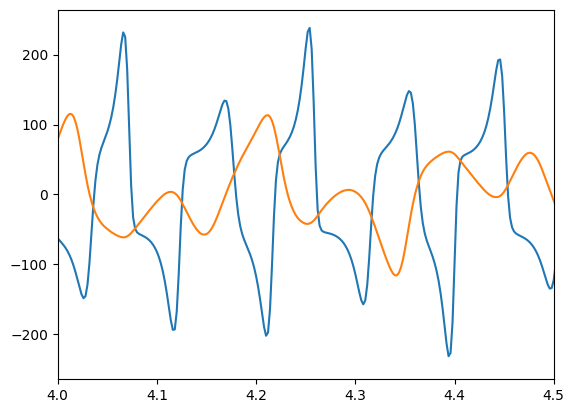

In [137]:
# @title simulated signal of the [eyes closed alzheimer]
file_path = 'drive/MyDrive/sim_eeg_signal'
file_group = 'EC_alzheimer'

temp_ec_alzheimer = mne.io.read_raw_eeglab(f'{file_path}/{file_group}/{file_group}0.set', preload=True)
temp_ec_alzheimer_data = temp_ec_alzheimer.get_data()
temp_ec_alzheimer_time = temp_ec_alzheimer.times

plt.figure()
plt.plot(temp_ec_alzheimer_time, temp_ec_alzheimer_data[0], label='x3')
plt.plot(temp_ec_alzheimer_time, temp_ec_alzheimer_data[1], label='x4')
plt.xlim(4, 4.5)
plt.show()

# Comments
From the comparison the conventional [global field synchronization] has the difficulty to pick up the synchronization if the chosen frequency interval is huge (e.g. 0.1Hz). Concurrently, the computation time will be long if the frequency interval is small (e.g. 0.001Hz).

Based on the results shown above, the [global field synchronization] shows the same results for both [eyes closed healthy] and [eyes closed alzheimer] cases. While in the frequency spectrum shows the disparity in term of frequency's amplitude in the range of 0.5Hz to 50Hz. The failure of detecting the disparity is not just due to the frequency interval, but also caused by the number of signals of the system. Since the demonstrated system only consists of 2 signals, hence it will always able to reduce the 2 dimensions (complex plane) to 1 dimension. Consequently, the [global field synchronization] will always be 1.

On contrary, [cross synchrony entropy] is more computationaly efficiency in computing the synchronization of the system. This is because the phase difference can be easily compared once the signals has undergone Hilbert transform. Also, having the cosine of the phase difference able to restrict the distribution to the range of -1 to 1 for Shannon entropy calculation. From the result, [eyes closed healthy] has lower [cross synchrony entropy] compared to [eyes closed alzheimer] in the frequency range of 0.5Hz to 50Hz. This would indicate that [eyes closed healthy] has the signals oscillate in phase with different region of the brain than [eyes closed alzheimer].